<a href="https://colab.research.google.com/github/pallavmarch/WebScraping_PsychologyToday/blob/main/psychologytoday_webscraping_dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install pgeocode
import pgeocode

pd.set_option("display.max_columns", None)
df=pd.read_csv("/content/therapists_profiles_data_Texas.csv",encoding='latin-1')

In [2]:
df[df['Name'] == 'Kathy Lee Siepker']

,Profile URL,Name,Title,Location,State,ZIP Code,Phone,Individual Sessions ($),Couple Sessions ($),Pay By,Insurance,Top Specialties,Expertise,Types of Therapy,Personal Statement,Verified by Psychology Today,In Practice (years),Membership,Certificate,Attended University,Major/Degree,Graduation Year,Qualifications,Endorsement Count,Endorsed By,Age,Participants,Communities,Religion,I also speak
5743,https://www.psychologytoday.com/us/therapists/...,Kathy Lee Siepker,"Clinical Social Work/Therapist,PhD,LCSW,CDP","Flower Mound, TX 75028(214) 692-2076",TX,75028,(214) 692-2076,$150,$150,"ACH Bank transfer, American Express, Discover,...",Aetna | BlueCross and BlueShield | Carelon Beh...,Anxiety | Depression | Dementia,Career Counseling | Coping Skills | Emotional ...,Coaching | Cognitive Behavioral (CBT) | Cultur...,"I am a licensed clinical social worker, therap...",Yes,4,Not Found,National Council of Certified Dementia Practit...,The Ohio State University (PhD); Wash U (MSW),Social Work,2014,Verified byPsychology TodayLicensed by State o...,1,Jamie English - Clinical Social Work/Therapist...,Adults | Elders (65+),Individuals | Couples | Family,Bisexual Allied | Gay Allied | HIV / AIDS Alli...,Not Found,Korean


In [4]:
print(len(df[df['Location'].isnull()]))
df.dropna(subset=['Location'], inplace=True)
print(len(df[df['Location'].isnull()]))

0
0


## Adding columns

In [5]:
df['Age'] = df['Age'].replace({'Elders (65+)': 'Elders'})
df['Dementia'] = df['Expertise'].str.lower().str.contains('dementia') | df['Top Specialties'].str.lower().str.contains('dementia')
df['Autism'] = df['Expertise'].str.lower().str.contains('autism') | df['Top Specialties'].str.lower().str.contains('autism')
df['Depression'] = df['Expertise'].str.lower().str.contains('depression') | df['Top Specialties'].str.lower().str.contains('depression')
df['Elders (65+)']=df['Age'].str.lower().str.contains('elders')
df['ZIP Code']=df['ZIP Code'].astype(int)

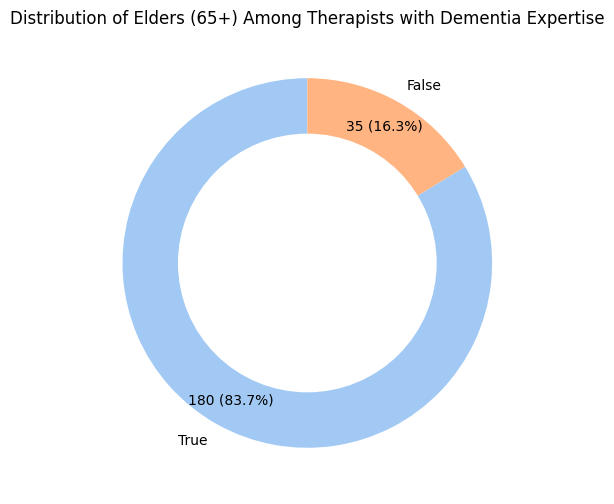

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant data
data = df[df['Dementia'] == True]['Elders (65+)'].value_counts()

# Labels and sizes
labels = data.index
sizes = data.values

# Define color palette
colors = sns.color_palette("pastel", len(labels))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Create the donut chart
wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, startangle=90, pctdistance=0.85, colors=colors,
    autopct=lambda p: f'{int(round(p * sum(sizes) / 100))} ({p:.1f}%)',  # Show value + percentage
    textprops={'fontsize': 10}
)

# Draw a circle in the center to create a donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax.add_artist(centre_circle)

# Set title
plt.title('Distribution of Elders (65+) Among Therapists with Dementia Expertise')

# Show plot
plt.show()


## Adding county, city

In [11]:
# Initialize the geocoder for US ZIP codes
nomi = pgeocode.Nominatim('us')

# Function to fetch city and county from ZIP Code
def get_location_info(zip_code):
    location = nomi.query_postal_code(zip_code)
    return pd.Series([location['place_name'], location['county_name']])

df[['City', 'County']] = df['ZIP Code'].astype(str).apply(get_location_info)

### DEMENTIA

In [33]:
Dementia=df[df['Dementia']==True]

Dementia=Dementia[['Name','Title', 'Location', 'City', 'County','ZIP Code', 'State',
       'Individual Sessions ($)', 'Couple Sessions ($)',
       'Insurance', 'Top Specialties', 'Expertise', 'Types of Therapy',
       'In Practice (years)', 'Membership', 'Certificate',
       'Major/Degree', 'Graduation Year', 'I also speak', 'Dementia','Elders (65+)']]

#Dementia['Individual Sessions ($)'] = Dementia['Individual Sessions ($)'].replace({'Not Found': '0'}).str.replace('$', '').str.replace(' ', '').astype(float)
#Dementia['Couple Sessions ($)'] = Dementia['Couple Sessions ($)'].replace({'Not Found': '0'}).str.replace('$', '').str.replace(' ', '').astype(float)
#Dementia['In Practice (years)'] = Dementia['In Practice (years)'].replace({'Not Found': '0'}).astype(float)

In [34]:
cols_to_clean = ['Individual Sessions ($)', 'Couple Sessions ($)', 'In Practice (years)']

# Clean and convert columns to integers while handling missing values
Dementia[cols_to_clean] = (
    Dementia[cols_to_clean]
    .replace('Not Found', np.nan)  # Replace 'Not Found' with NaN
    .apply(lambda x: x.str.replace(r'[$ ]', '', regex=True).astype(float))  # Remove $, spaces, convert to float
    .astype('Int64')  # Convert to nullable integer type
)

# Generate value counts for each column and merge them side by side
value_counts_list = [
    Dementia[col].value_counts().astype(int).rename_axis(col).reset_index(name='Count')
    for col in cols_to_clean
]
side_by_side = pd.concat(value_counts_list, axis=1)


# Create pivot table
pivot_table1 = pd.pivot_table(Dementia,
                              values=cols_to_clean,
                              aggfunc=['mean', 'median', 'min', 'max', 'std', 'count', 'nunique', lambda x: x.isnull().sum()],
                              columns=['Dementia'],
                              dropna=True)

pivot_table1 = pivot_table1.applymap(lambda x: int(x) if not pd.isna(x) else x)

# Display styled pivot table
pivot_table1.style.background_gradient(cmap='Blues').format("{:.0f}")  # Remove decimals


<ipython-input-34-7d8e76e173bd>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_table1 = pivot_table1.applymap(lambda x: int(x) if not pd.isna(x) else x)


,mean,median,min,max,std,count,nunique,
Dementia,True,True,True,True,True,True,True,True
Couple Sessions ($),160,150,50,350,51,94,32,121
In Practice (years),14,12,1,41,9,132,38,83
Individual Sessions ($),141,150,25,250,40,167,35,48


However There are rows with blank Individual Sessions ($), couple Sessions ($) and In Practice (years) which are not considered 0 instead of blank

In [ ]:
def transform_insurance(row):
  insurance = str(row).lower()
  if "not found" in insurance:
    return "No"
  elif insurance == "out of network":
    return "Out of Network"
  elif "medicare" in insurance and "medicaid" in insurance:
    return "Medicare|Medicaid"
  elif "medicare" in insurance:
    return "Medicare"
  elif "medicaid" in insurance:
    return "Medicaid"
  else:
    return "Yes"

Dementia['Insurance_Category'] = Dementia['Insurance'].apply(transform_insurance)


Dementia.insert(8, 'Insurance_Category', Dementia.pop('Insurance_Category'))


In [36]:
Dementia['Insurance_Category'].value_counts()

,count
Insurance_Category,
Yes,85
Medicare,45
No,36
Out of Network,21
Medicare|Medicaid,16
Medicaid,12


<ipython-input-49-9416b5c81763>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=insurance_counts, y='Insurance Category', x='Count', palette='Blues_r')


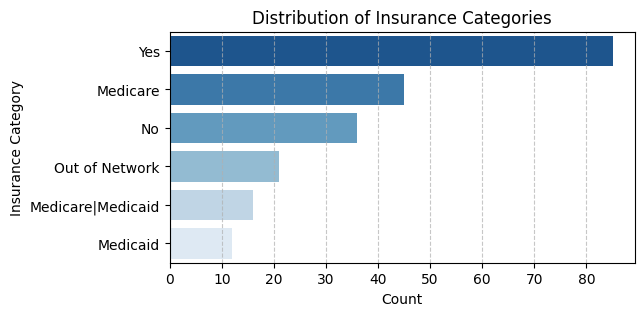

In [49]:

insurance_counts = Dementia['Insurance_Category'].value_counts().reset_index()
insurance_counts.columns = ['Insurance Category', 'Count']

plt.figure(figsize=(6, 3))
sns.barplot(data=insurance_counts, y='Insurance Category', x='Count', palette='Blues_r')


plt.title("Distribution of Insurance Categories")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()